Parallel optimization

In [5]:
from skopt import Optimizer
from skopt.space import Real
from joblib import Parallel, delayed
# example objective taken from skopt
from skopt.benchmarks import branin

optimizer = Optimizer(
    dimensions=[Real(-5.0, 10.0), Real(0.0, 15.0)],
    random_state=1,
    base_estimator='gp'
)

for i in range(10):
    x = optimizer.ask(n_points=4)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(branin)(v) for v in x)  # evaluate points in parallel
    optimizer.tell(x, y)

# takes ~ 20 sec to get here
print(min(optimizer.yi))  # print the best objective found

0.4011701911081005


Interruptible optimization runs with checkpoints

In [7]:
from skopt import gp_minimize
from skopt import callbacks
from skopt.callbacks import CheckpointSaver

noise_level = 0.1


def obj_fun(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() \
        * noise_level

checkpoint_saver = CheckpointSaver("./checkpoint.pkl", compress=9) # keyword arguments will be passed to `skopt.dump`

gp_minimize(obj_fun,            # the function to minimize
            [(-20.0, 20.0)],    # the bounds on each dimension of x
            x0=[-20.],          # the starting point
            acq_func="LCB",     # the acquisition function (optional)
            n_calls=10,         # number of evaluations of f including at x0
            n_random_starts=3,  # the number of random initial points
            callback=[checkpoint_saver],
            # a list of callbacks including the checkpoint saver
            random_state=777)

from skopt import load

res = load('./checkpoint.pkl')

x0 = res.x_iters
y0 = res.func_vals

gp_minimize(obj_fun,            # the function to minimize
            [(-20.0, 20.0)],    # the bounds on each dimension of x
            x0=x0,              # already examined values for x
            y0=y0,              # observed values for x0
            acq_func="LCB",     # the acquisition function (optional)
            n_calls=10,         # number of evaluations of f including at x0
            n_random_starts=3,  # the number of random initialization points
            callback=[checkpoint_saver],
            random_state=777)

          fun: -0.17152174160319505
    func_vals: array([ 0.16067992, -0.02864208,  0.07365333,  0.0651153 , -0.04671516,
        0.0983707 ,  0.16310306,  0.02670645,  0.02139812, -0.17152174,
        0.08029928, -0.02400044,  0.04089588,  0.05133686,  0.08185597,
       -0.0412193 ,  0.1914539 , -0.03709999,  0.09388424, -0.11346955])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=655685735), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=655685735), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
       

Tuning a scikit-learn estimator with skopt

In [10]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

from skopt.space import Real, Integer
from skopt.utils import use_named_args


# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.9275'

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

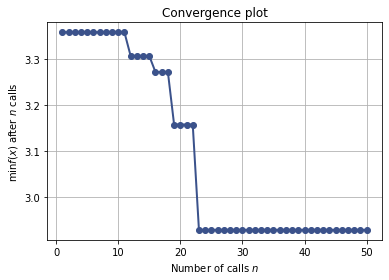

In [12]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

Scikit-learn hyperparameter search wrapper

In [13]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.985894580549369
test score: 0.9822222222222222


In [14]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([
    ('model', SVC())
])

# single categorical value of 'model' parameter is
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
linsvc_search = {
    'model': [LinearSVC(max_iter=1000)],
    'model__C': (1e-6, 1e+6, 'log-uniform'),
}

# explicit dimension classes can be specified like this
svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(svc_search, 40), (linsvc_search, 16)],
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

C:\Users\James\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\James\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\James\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\James\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\James\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\James\AppData\Roaming\Python\Python38\sit

val. score: 0.9866369710467705
test score: 0.9844444444444445
best params: OrderedDict([('model', SVC(C=1e-06, degree=2, gamma=0.5486326965114388, kernel='poly')), ('model__C', 1e-06), ('model__degree', 2), ('model__gamma', 0.5486326965114388), ('model__kernel', 'poly')])


NameError: name 'plt' is not defined

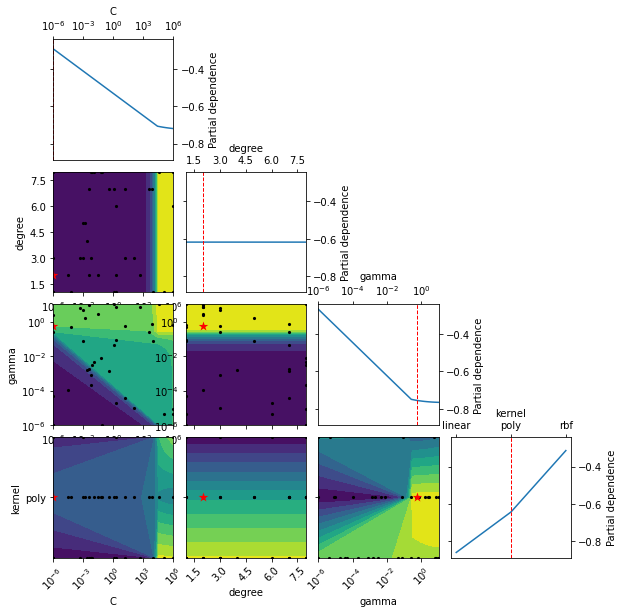

In [15]:
_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

NameError: name 'plt' is not defined

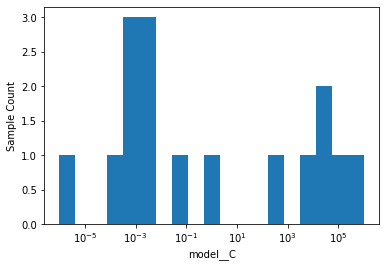

In [16]:
_ = plot_histogram(opt.optimizer_results_[1], 1)
plt.show()

Bayesian optimization with skopt

In [18]:
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

Automatically created module for IPython interactive environment


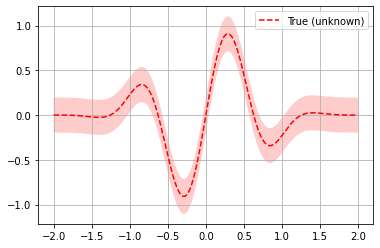

In [19]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

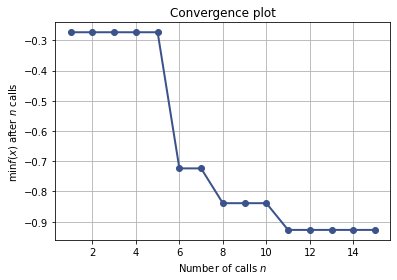

In [21]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

from skopt.plots import plot_convergence
plot_convergence(res);

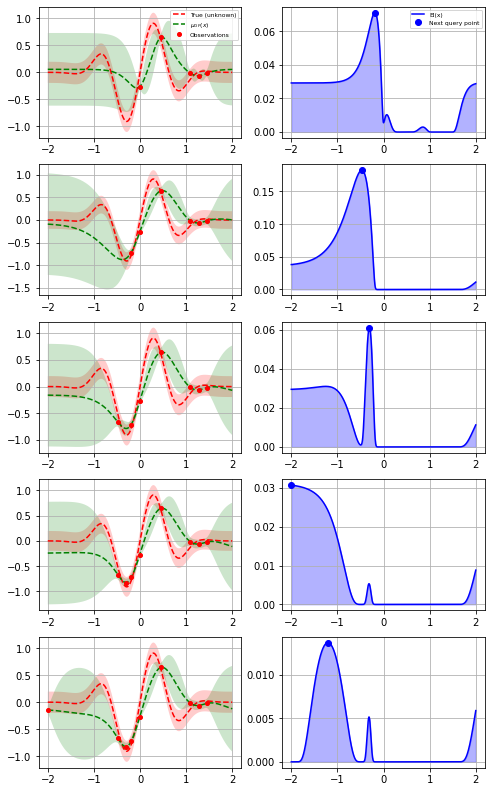

In [22]:
plt.rcParams["figure.figsize"] = (8, 14)


def f_wo_noise(x):
    return f(x, noise_level=0)

for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

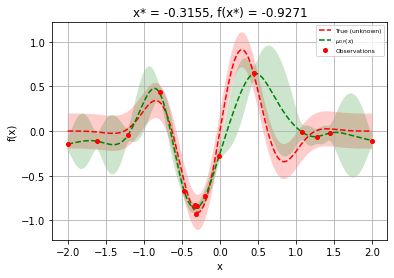

In [23]:
plt.rcParams["figure.figsize"] = (6, 4)

# Plot f(x) + contours
_ = plot_gaussian_process(res, objective=f_wo_noise,
                          noise_level=noise_level)

plt.show()

Use different base estimators for optimization

Automatically created module for IPython interactive environment


[]

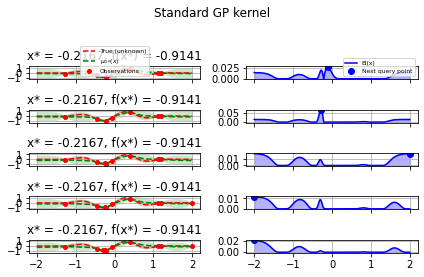

In [25]:
print(__doc__)

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import Optimizer

noise_level = 0.1

# Our 1D toy problem, this is the function we are trying to
# minimize


def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level


def objective_wo_noise(x):
    return objective(x, noise_level=0)

opt_gp = Optimizer([(-2.0, 2.0)], base_estimator="GP", n_initial_points=5,
                acq_optimizer="sampling", random_state=42)

def plot_optimizer(res, n_iter, max_iters=5):
    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 1)
    # Plot GP(x) + contours
    ax = plot_gaussian_process(res, ax=ax,
                               objective=objective_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=True,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])
    # Plot EI(x)
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 2)
    ax = plot_gaussian_process(res, ax=ax,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=True, show_acq_func=True,
                               show_observations=False,
                               show_mu=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])
        
fig = plt.figure()
fig.suptitle("Standard GP kernel")
for i in range(10):
    next_x = opt_gp.ask()
    f_val = objective(next_x)
    res = opt_gp.tell(next_x, f_val)
    if i >= 5:
        plot_optimizer(res, n_iter=i-5, max_iters=5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.plot()        

Test different kernels

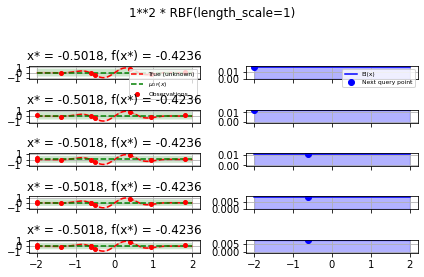

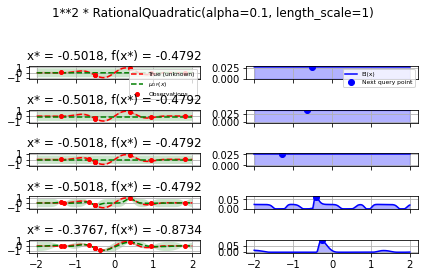

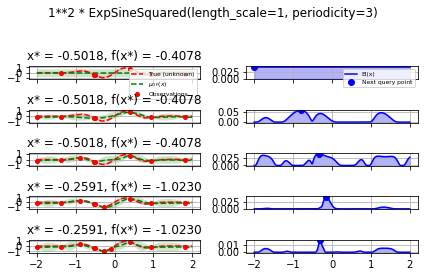

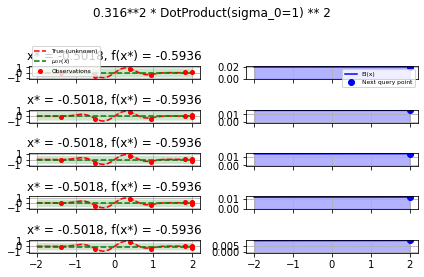

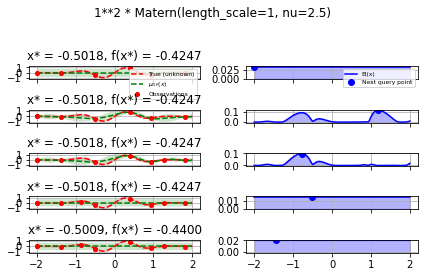

In [27]:
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
# Gaussian process with Matérn kernel as surrogate model

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=2.5)]

for kernel in kernels:
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise_level ** 2,
                                   normalize_y=True, noise="gaussian",
                                   n_restarts_optimizer=2
                                   )
    opt = Optimizer([(-2.0, 2.0)], base_estimator=gpr, n_initial_points=5,
                    acq_optimizer="sampling", random_state=42)
    fig = plt.figure()
    fig.suptitle(repr(kernel))
    for i in range(10):
        next_x = opt.ask()
        f_val = objective(next_x)
        res = opt.tell(next_x, f_val)
        if i >= 5:
            plot_optimizer(res, n_iter=i - 5, max_iters=5)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Comparing surrogate models

Automatically created module for IPython interactive environment


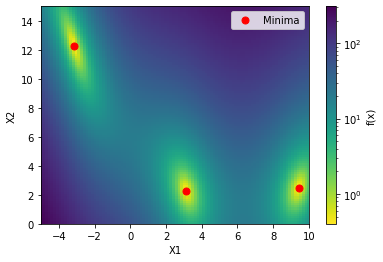

In [28]:
print(__doc__)
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt

from skopt.benchmarks import branin as _branin

def branin(x, noise_level=0.):
    return _branin(x) + noise_level * np.random.randn()

from matplotlib.colors import LogNorm


def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))

    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(),
                                    vmax=fx.max()),
                       cmap='viridis_r')

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14,
            lw=0, label="Minima")

    cb = fig.colorbar(cm)
    cb.set_label("f(x)")

    ax.legend(loc="best", numpoints=1)

    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])


plot_branin()

In [29]:
from functools import partial
from skopt import gp_minimize, forest_minimize, dummy_minimize

func = partial(branin, noise_level=2.0)
bounds = [(-5.0, 10.0), (0.0, 15.0)]
n_calls = 60

def run(minimizer, n_iter=5):
    return [minimizer(func, bounds, n_calls=n_calls, random_state=n)
            for n in range(n_iter)]

# Random search
dummy_res = run(dummy_minimize)

# Gaussian processes
gp_res = run(gp_minimize)

# Random forest
rf_res = run(partial(forest_minimize, base_estimator="RF"))

# Extra trees
et_res = run(partial(forest_minimize, base_estimator="ET"))

from skopt.plots import plot_convergence

plot = plot_convergence(("dummy_minimize", dummy_res),
                        ("gp_minimize", gp_res),
                        ("forest_minimize('rf')", rf_res),
                        ("forest_minimize('et)", et_res),
                        true_minimum=0.397887, yscale="log")

plot.legend(loc="best", prop={'size': 6}, numpoints=1)

KeyboardInterrupt: 

Async optimization Loop

Automatically created module for IPython interactive environment


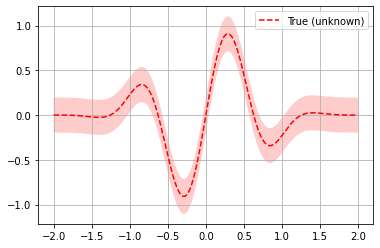

In [32]:
print(__doc__)

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer

noise_level = 0.1

def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

def objective_wo_noise(x, noise_level=0):
    return objective(x, noise_level=0)

# Plot f(x) + contours
plt.set_cmap("viridis")
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = np.array([objective(x_i, noise_level=0.0) for x_i in x])
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [35]:
opt = Optimizer([(-2.0, 2.0)], "GP", acq_func="EI",
                acq_optimizer="sampling",
                initial_point_generator="lhs")

# To obtain a suggestion for the point at which to evaluate the objective
# you call the ask() method of opt:

next_x = opt.ask()
print(next_x)

f_val = objective(next_x)
opt.tell(next_x, f_val)

[-0.2822357847602339]


          fun: -0.7842486392365786
    func_vals: array([-0.78424864])
       models: []
 random_state: RandomState(MT19937) at 0x23C441EA140
        space: Space([Real(low=-2.0, high=2.0, prior='uniform', transform='normalize')])
        specs: {'args': {'dimensions': [(-2.0, 2.0)], 'base_estimator': 'GP', 'n_random_starts': None, 'n_initial_points': 10, 'initial_point_generator': 'lhs', 'n_jobs': 1, 'acq_func': 'EI', 'acq_optimizer': 'sampling', 'random_state': None, 'model_queue_size': None, 'acq_func_kwargs': None, 'acq_optimizer_kwargs': None}, 'function': 'Optimizer'}
            x: [-0.2822357847602339]
      x_iters: [[-0.2822357847602339]]

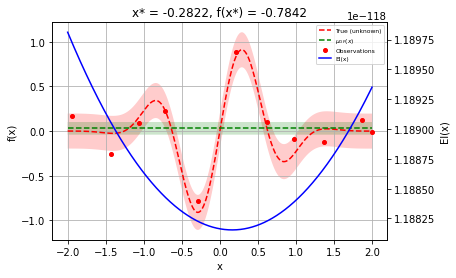

In [37]:
for i in range(9):
    next_x = opt.ask()
    f_val = objective(next_x)
    res = opt.tell(next_x, f_val)
    
_ = plot_gaussian_process(res, objective=objective_wo_noise,
                          noise_level=noise_level,
                          show_next_point=False,
                          show_acq_func=True)
plt.show()

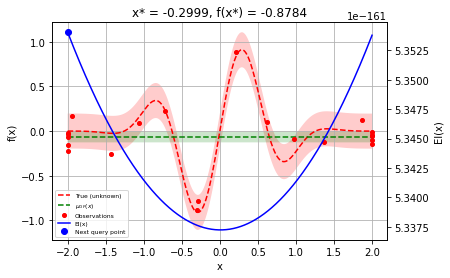

In [38]:
for i in range(10):
    next_x = opt.ask()
    f_val = objective(next_x)
    res = opt.tell(next_x, f_val)

_ = plot_gaussian_process(res, objective=objective_wo_noise,
                          noise_level=noise_level,
                          show_next_point=True,
                          show_acq_func=True)
plt.show()

Comparing initial sampling methods

Automatically created module for IPython interactive environment


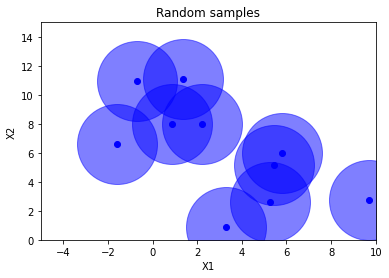

In [40]:
print(__doc__)
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from skopt.space import Space
from skopt.sampler import Sobol
from skopt.sampler import Lhs
from skopt.sampler import Halton
from skopt.sampler import Hammersly
from skopt.sampler import Grid
from scipy.spatial.distance import pdist

def plot_searchspace(x, title):
    fig, ax = plt.subplots()
    plt.plot(np.array(x)[:, 0], np.array(x)[:, 1], 'bo', label='samples')
    plt.plot(np.array(x)[:, 0], np.array(x)[:, 1], 'bo', markersize=80, alpha=0.5)
    # ax.legend(loc="best", numpoints=1)
    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])
    plt.title(title)

n_samples = 10

space = Space([(-5., 10.), (0., 15.)])
# space.set_transformer("normalize")

x = space.rvs(n_samples)
plot_searchspace(x, "Random samples")
pdist_data = []
x_label = []
pdist_data.append(pdist(x).flatten())
x_label.append("random")

D:\anaconda3\envs\yourenvname\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+10=10. 
  warnings.warn("The balance properties of Sobol' points require "


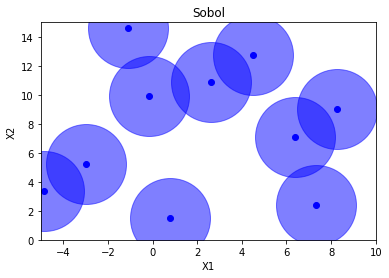

In [41]:
sobol = Sobol()
x = sobol.generate(space.dimensions, n_samples)
plot_searchspace(x, 'Sobol')
pdist_data.append(pdist(x).flatten())
x_label.append("sobol")

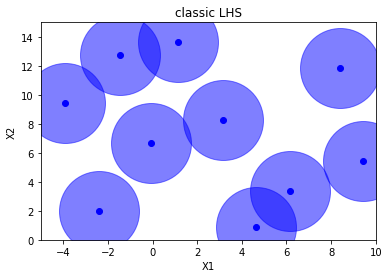

In [42]:
lhs = Lhs(lhs_type="classic", criterion=None)
x = lhs.generate(space.dimensions, n_samples)
plot_searchspace(x, 'classic LHS')
pdist_data.append(pdist(x).flatten())
x_label.append("lhs")

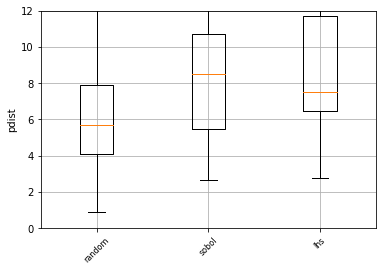

In [43]:
fig, ax = plt.subplots()
ax.boxplot(pdist_data)
plt.grid(True)
plt.ylabel("pdist")
_ = ax.set_ylim(0, 12)
_ = ax.set_xticklabels(x_label, rotation=45, fontsize=8)

Comparing initial point generation methods

In [46]:
print(__doc__)
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt

from skopt.benchmarks import hart6 as hart6_
# redefined `hart6` to allow adding arbitrary "noise" dimensions
def hart6(x, noise_level=0.):
    return hart6_(x[:6]) + noise_level * np.random.randn()

from skopt.benchmarks import branin as _branin

def branin(x, noise_level=0.):
    return _branin(x) + noise_level * np.random.randn()

from matplotlib.pyplot import cm
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize

def plot_convergence(result_list, true_minimum=None, yscale=None, title="Convergence plot"):

    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Number of calls $n$")
    ax.set_ylabel(r"$\min f(x)$ after $n$ calls")
    ax.grid()
    if yscale is not None:
        ax.set_yscale(yscale)
    colors = cm.hsv(np.linspace(0.25, 1.0, len(result_list)))

    for results, color in zip(result_list, colors):
        name, results = results
        n_calls = len(results[0].x_iters)
        iterations = range(1, n_calls + 1)
        mins = [[np.min(r.func_vals[:i]) for i in iterations]
                for r in results]
        ax.plot(iterations, np.mean(mins, axis=0), c=color, label=name)
        #ax.errorbar(iterations, np.mean(mins, axis=0),
        #             yerr=np.std(mins, axis=0), c=color, label=name)
    if true_minimum:
        ax.axhline(true_minimum, linestyle="--",
                   color="r", lw=1,
                   label="True minimum")
    ax.legend(loc="best")
    return ax


def run(minimizer, initial_point_generator,
        n_initial_points=10, n_repeats=1):
    return [minimizer(func, bounds, n_initial_points=n_initial_points,
                      initial_point_generator=initial_point_generator,
                      n_calls=n_calls, random_state=n)
            for n in range(n_repeats)]


def run_measure(initial_point_generator, n_initial_points=10):
    start = time.time()
    # n_repeats must set to a much higher value to obtain meaningful results.
    n_repeats = 1
    res = run(gp_minimize, initial_point_generator,
              n_initial_points=n_initial_points, n_repeats=n_repeats)
    duration = time.time() - start
    # print("%s %s: %.2f s" % (initial_point_generator,
    #                          str(init_point_gen_kwargs),
    #                          duration))
    return res

from functools import partial
example = "hart6"

if example == "hart6":
    func = partial(hart6, noise_level=0.1)
    bounds = [(0., 1.), ] * 6
    true_minimum = -3.32237
    n_calls = 40
    n_initial_points = 10
    yscale = None
    title = "Convergence plot - hart6"
else:
    func = partial(branin, noise_level=2.0)
    bounds = [(-5.0, 10.0), (0.0, 15.0)]
    true_minimum = 0.397887
    n_calls = 30
    n_initial_points = 10
    yscale="log"
    title = "Convergence plot - branin"
    
from skopt.utils import cook_initial_point_generator

# Random search
dummy_res = run_measure("random", n_initial_points)
lhs = cook_initial_point_generator(
    "lhs", lhs_type="classic", criterion=None)
lhs_res = run_measure(lhs, n_initial_points)
lhs2 = cook_initial_point_generator("lhs", criterion="maximin")
lhs2_res = run_measure(lhs2, n_initial_points)
sobol = cook_initial_point_generator("sobol", randomize=False,
                                     min_skip=1, max_skip=100)
sobol_res = run_measure(sobol, n_initial_points)
halton_res = run_measure("halton", n_initial_points)
hammersly_res = run_measure("hammersly", n_initial_points)
grid_res = run_measure("grid", n_initial_points)

plot = plot_convergence([("random", dummy_res),
                        ("lhs", lhs_res),
                        ("lhs_maximin", lhs2_res),
                        ("sobol", sobol_res),
                        ("halton", halton_res),
                        ("hammersly", hammersly_res),
                        ("grid", grid_res)],
                        true_minimum=true_minimum,
                        yscale=yscale,
                        title=title)

plt.show()

Automatically created module for IPython interactive environment


KeyboardInterrupt: 